## Pytorch Transfer Learning

What is Transfer Learning?
=> Transfer learning involves taking the parameter of what one model has learned on another dataset and applying them to our model.

* Pretrained model = foundation models

In [21]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


Import the code we've already covered

In [22]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [24]:
!nvidia-smi

Wed Nov 20 03:55:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              30W /  70W |    791MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [25]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [26]:
#.Setup dir paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and Dataloaders

Now we've got some data we'll turn them into dataloaders, by using the function in our `data_setup.py` file

With torchvision we've two ways of transforming data..

1. Manual transforms: we define the transforms for our data to go through
2. Automatically create transforms: Transforms are defined by the models for our data..

*__NOTE:__* When using pretrained model data is transformed the same way the model was trained on.

In [27]:
from going_modular.going_modular import data_setup
from torchvision import transforms

#.Creating transform for our pretrained model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

#.Getting data loaders with our functions
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b94ade8d3c0>,
 ['pizza', 'steak', 'sushi'])

## 2.2 Creating transforms from torchvision.models(auto-creation)

In latest version there is support for automatic data transforms and its done according to pre-trained models weights..

In [28]:
torchvision.__version__

'0.20.1+cu121'

In [29]:
#.Get the set for pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [30]:
#.Get transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [31]:
#.Create dataloader using above auto transform
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms, # use auto transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b94ade8f730>,
 ['pizza', 'steak', 'sushi'])

## Getting pretrained model:
There are various places to get the pretrained model such as <br>

1. Pytorch domain libs
2. libs like timm
3. HuggingFaceHub(gives variety)
4. PapersWithCode(For models across different problem spaces/domains)

### Which pretrained model should we use?
=> *Experiment*
The whole idea is to pick a well performing model and customize it for our problem statement.

Things to consider though:
1. Speed - how much time it needs to execute
2. Size - space it take to store and execute.
3. Performance - are the results generated according to expectations
4. Env: the environment the model will be working on. eg: on car device, or a data-center server,

In [32]:
#.Setting up the pretrained model, we're using EffNetB0

#.Old method
#  model = torchvision.models.efficientnet_b0(pretrained=True)

#.New way
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [33]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [34]:
#.Print summary with torch info
from torchinfo import summary
summary(model=model,
      input_size=(1, 3, 224, 224),
      col_names=["input_size", "output_size", "num_params", "trainable"],
      col_width=20,
      row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will 'freeze' the base layers of a pretrained/foundation model and update the output layers to suit our problem

In [35]:
#.Freeze the base layers of eff-net0
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False #by switichng off gradince tracking we don't modify the pretrained weight/baises and used them as is
summary(model=model,
      input_size=(1, 3, 224, 224),
      col_names=["input_size", "output_size", "num_params", "trainable"],
      col_width=20,
      row_settings=["var_names"]
)
#.Change the output layer

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [36]:
 #.update the classifier head of our model
from torch import nn
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True))
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [37]:
summary(model=model,
      input_size=(1, 3, 224, 224),
      col_names=["input_size", "output_size", "num_params", "trainable"],
      col_width=20,
      row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4.Train the above model

In [40]:
from going_modular.going_modular import engine
from timeit import default_timer as timer
#.Define loss/optim
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#.Set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer = optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
end_time = timer()
print(results)
print(f'Training time:{end_time-start_time:.3f} sec')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3344 | train_acc: 0.9570 | test_loss: 0.4234 | test_acc: 0.8456
Epoch: 2 | train_loss: 0.2943 | train_acc: 0.9648 | test_loss: 0.4149 | test_acc: 0.8352
Epoch: 3 | train_loss: 0.2935 | train_acc: 0.9492 | test_loss: 0.4375 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.3579 | train_acc: 0.8516 | test_loss: 0.3904 | test_acc: 0.8456
Epoch: 5 | train_loss: 0.3089 | train_acc: 0.9648 | test_loss: 0.4089 | test_acc: 0.8561
{'train_loss': [0.3344241436570883, 0.2942880392074585, 0.29354817047715187, 0.3579329941421747, 0.30893314629793167], 'train_acc': [0.95703125, 0.96484375, 0.94921875, 0.8515625, 0.96484375], 'test_loss': [0.4234355390071869, 0.41488775610923767, 0.4374876121679942, 0.3903558850288391, 0.4089354674021403], 'test_acc': [0.8456439393939394, 0.8352272727272728, 0.8248106060606061, 0.8456439393939394, 0.8560606060606061]}
Training time:11.847 sec


## 5.Evaluate model and plot loss curve


File not found, downloading it...


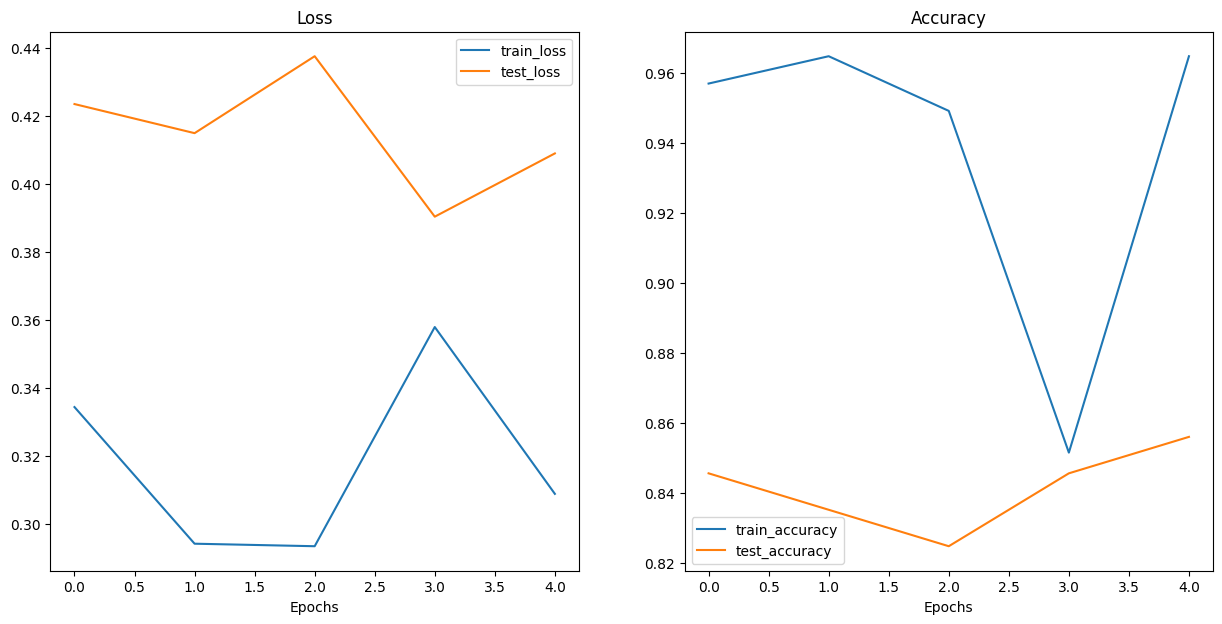

In [41]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f'File not found, downloading it...')
  with open('helper_functions.py', 'wb') as f:
    import requests
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    f.write(request.content)
  from helper_functions import plot_loss_curves

plot_loss_curves(results)